In [1]:
# Install library for reading JPK File
%pip uninstall jpkreader --yes
%pip install git+https://github.com/jlopezalo/pyjpkreader

Found existing installation: jpkreader 0.0.1
Uninstalling jpkreader-0.0.1:
  Successfully uninstalled jpkreader-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyjpkreader to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-e0uxihqg
  Running command git clone -q https://github.com/jlopezalo/pyjpkreader /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-e0uxihqg
  Created wheel for jpkreader: filename=jpkreader-0.0.1-py3-none-any.whl size=10194 sha256=600eac7734827577961b4f4459ef58988d7a45755cb91c20056731675dbe1711
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-3cwjiw5_/wheels/23/c0/8e/c378f28c65b0199f6092b6aa45e090c1ed6b4093f3adb03a15
Successfully built jpkreader
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-muagl7v4
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-muagl7v4
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=23324 sha256=3b96643bc079551ab936c77eb0efc6ab8d4996dc4b1d2f163e976e01ba43989f
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-4fgefgyl/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Get file reader from library
from jpkreader import load_jpk_file

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.utils.signal_processing import *
from pyafmrheo.hertz_fit import HertzFit
from pyafmrheo.models.rheology import ComputeBh

In [4]:
# Define global variables
file_path = '/Users/javierlopez/Desktop/Gels-16122021/AGAROSE1/vDrag/map-data-2021.12.16-20.07.19.893.jpk-force-map'
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [5]:
file = load_jpk_file(file_path)

In [6]:
file_id = file.file_id
file_type = file.file_type
file_metadata = file.file_metadata
file_data = file.data
piezo_image = file.piezo_image
quality_map = file.quality_map

In [7]:
closed_loop = file_metadata['z_closed_loop_status']
file_deflection_sensitivity = file_metadata['original_deflection_sensitivity'] #nm/V
file_spring_constant = file_metadata['original_spring_constant'] #N/m
height_channel = file_metadata['height_channel_key']

print(closed_loop)

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

False


In [8]:
curve_idx = 9
force_curve = file_data[curve_idx]
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = [*extend_segments, *pause_segments, *modulation_segments, *retract_segments]
force_curve_segments = sorted(force_curve_segments, key=lambda x: int(x[0]))

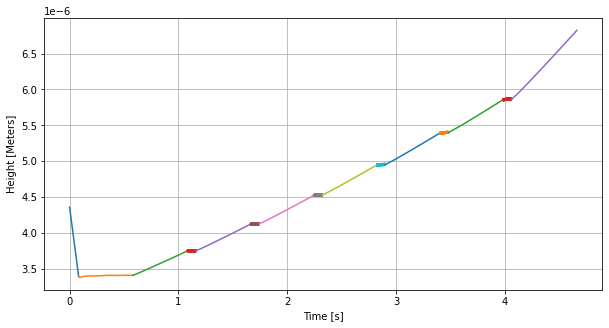

In [9]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

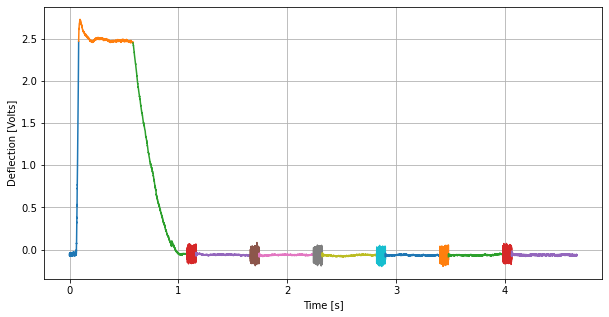

In [10]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

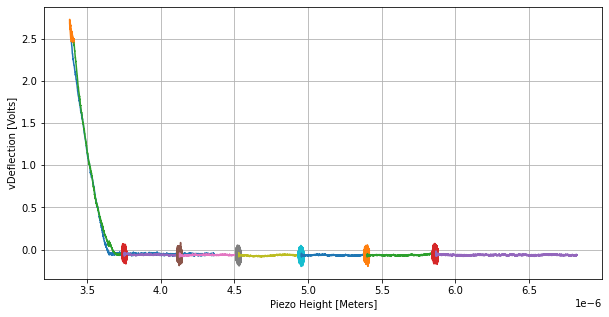

In [11]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [12]:
# Get distances from the sample, needed to compute Bh
x0 = 0
distances = []
sorted_ret_segments = sorted(retract_segments, key=lambda x: int(x[0]))
for first_ret_seg_id, first_ret_seg in sorted_ret_segments[:-1]:
    distance_from_sample = -1 * first_ret_seg.segment_metadata['ramp_size'] + x0 # Negative
    distances.append(distance_from_sample * 1e-9)
    x0 = distance_from_sample

print(*distances)

5.000000000000001e-07 1.0000000000000002e-06 1.5e-06 2.0000000000000003e-06 2.5e-06 3e-06


In [13]:
# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]
app_deflection, app_height, app_time =\
    preprocess_segment(first_ext_seg, height_channel, deflection_sensitivity)

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
ret_deflection, ret_height, ret_time =\
    preprocess_segment(last_ret_seg, height_channel, deflection_sensitivity)

if pause_segments:
    # Get first pause segment
    first_pause_seg_id, first_pause_seg = pause_segments[0]
    pau_deflection, pau_height, pau_time =\
        preprocess_segment(first_pause_seg, height_channel, deflection_sensitivity)

if modulation_segments:
    modulation_data = {}
    for seg_id, seg_data in modulation_segments:
        segment_data = {}
        mod_deflection, mod_height, mod_time =\
            preprocess_segment(seg_data, height_channel, deflection_sensitivity)
        segment_data['height'] = mod_height
        segment_data['deflection'] = mod_deflection
        segment_data['time'] = mod_time
        modulation_data[seg_id] = segment_data

In [14]:
# Shift height
xzero = ret_height[-1] # Maximum height
app_height = xzero - app_height
ret_height = xzero - ret_height
if pause_segments:
    pau_height = xzero - pau_height
if modulation_segments:
    for segment_data in modulation_data.values():
        segment_data['height'] = xzero - segment_data['height']

In [15]:
if modulation_segments:
    for segment_data in modulation_data.values():
        mod_indentation, mod_force =\
            get_force_vs_indentation_curve(segment_data['height'], segment_data['deflection'], [0,0], spring_constant)
        segment_data['indentation'] = mod_indentation
        segment_data['force'] = mod_force

In [16]:
results = []

for seg_id, seg_data in modulation_segments:
    frequency = seg_data.segment_metadata["frequency"]
    data = modulation_data[seg_id]
    time = data['time']
    indentation = data['indentation']
    force = data['force']
    deltat = time[1] - time[0]
    fs = 1 / deltat
    indentation, force, time =\
         detrend_rolling_average(frequency, indentation, force, time, 'indentation', 'force', [])
    Bh, Hd, gamma2 = ComputeBh(force, indentation, fs, frequency, fi=18)
    results.append((frequency, Bh, Hd, gamma2))

results = sorted(results, key=lambda x: int(x[0]))
frequencies_results = [x[0] for x in results]
Bh_results = [x[1] for x in results]
Hd_results = [x[2] for x in results]

The frequency found at index 499.9177766814669 does not match with the frequency applied 500.0
The frequency found at index 499.9177766814669 does not match with the frequency applied 500.0
The frequency found at index 499.9177766814669 does not match with the frequency applied 500.0
The frequency found at index 499.9177766814669 does not match with the frequency applied 500.0
The frequency found at index 499.9177766814669 does not match with the frequency applied 500.0
The frequency found at index 499.9177766814669 does not match with the frequency applied 500.0


/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/spectral.py:1812: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


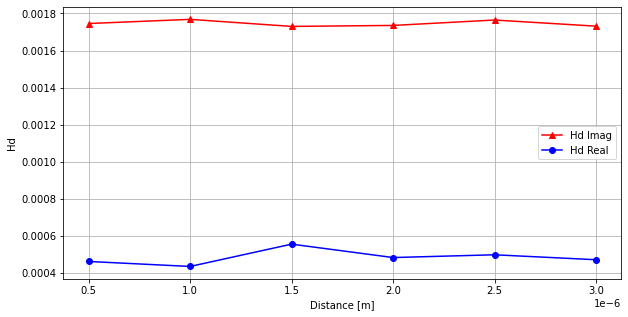

In [19]:
plt.plot(distances, np.imag(Hd_results), "r^-", label="Hd Imag")
plt.plot(distances, np.real(Hd_results), "bo-", label="Hd Real")
plt.xlabel("Distance [m]")
plt.ylabel("Hd")
plt.grid()
plt.legend()
plt.show()

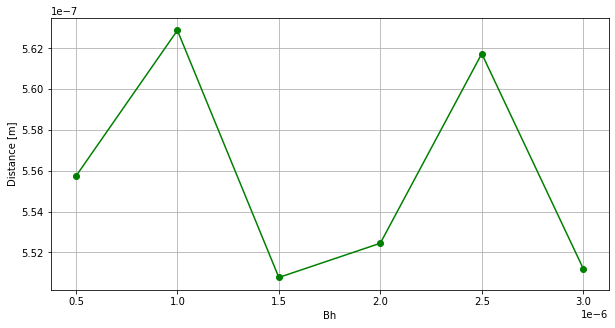

In [18]:
plt.plot(distances, Bh_results, "go-")
plt.xlabel("Bh")
plt.ylabel("Distance [m]")
plt.grid()
plt.show()